# Clustering analysis on 10k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *
from utils import *

tf.enable_eager_execution()
tf.executing_eagerly()

Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 100,
    'layers_enc_dim': [1000, 500, 400, 300, 200],
    'layers_dec_dim': [200, 300, 400, 500, 1000],
    'layers_dis_dim': [200, 300, 400, 500, 1000],
    'batch_size': 1000,
    'epochs': 30
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,30,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,100,dimension of latent space Z
layer_1_enc_dim,1000,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 1000)         2146000     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 1000)         4000        H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 1000)         0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 30/30, rec. loss: 0.785137, dis. loss: 0.200078


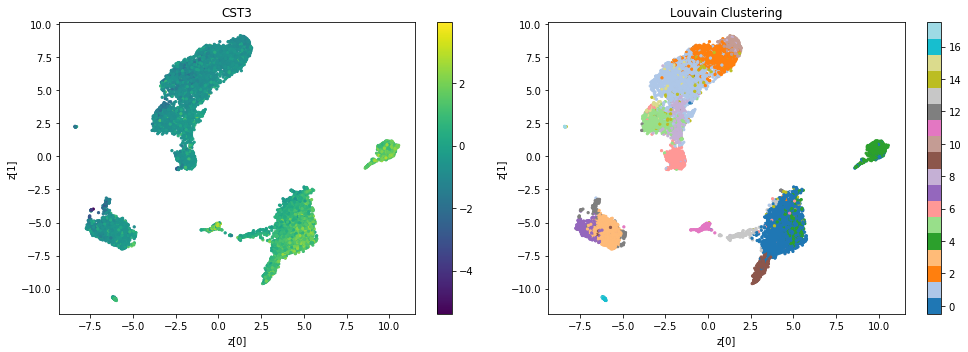

Training completed.
All networks exported in h5 format.


In [12]:
# Training...

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC10k/

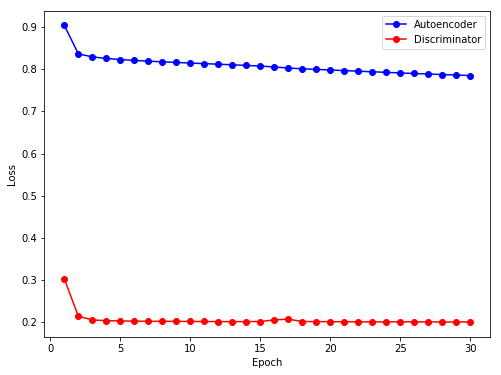

In [13]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

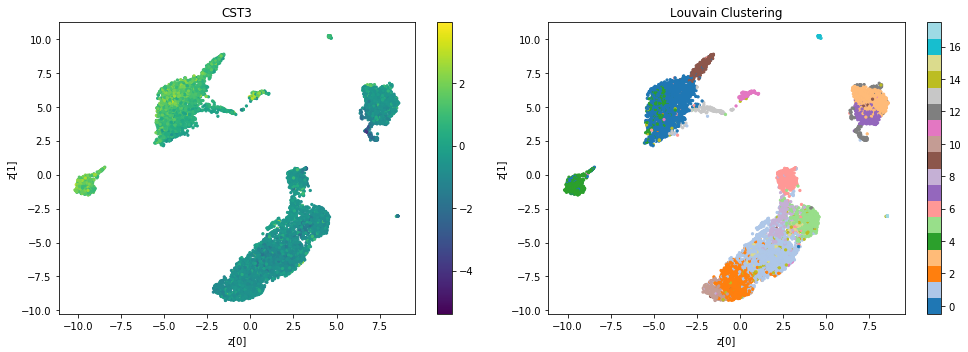

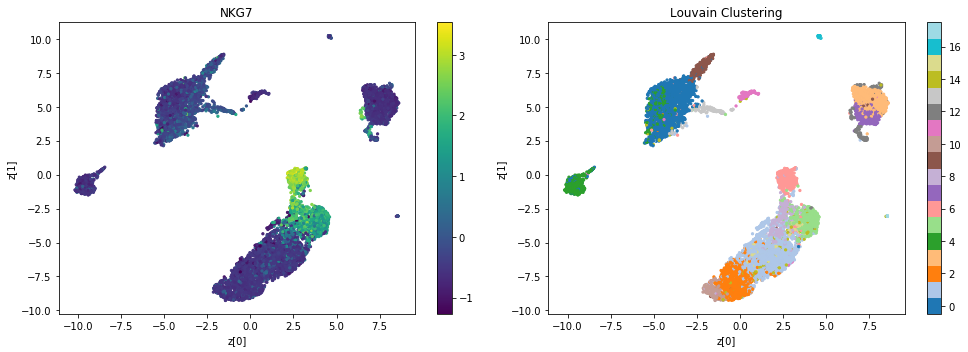

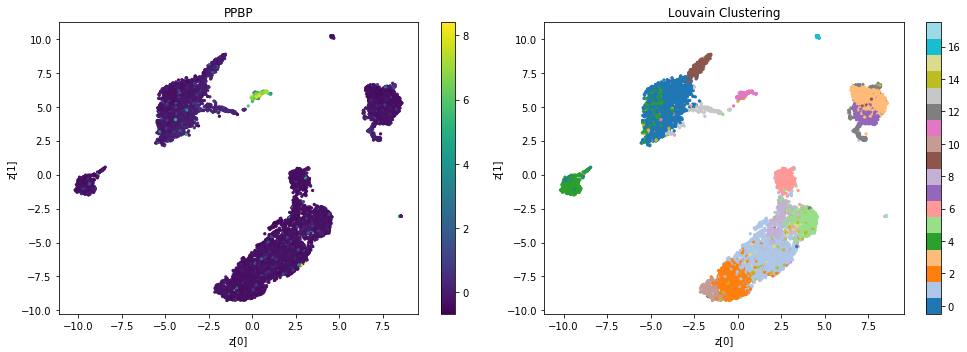

In [14]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/AAE1/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

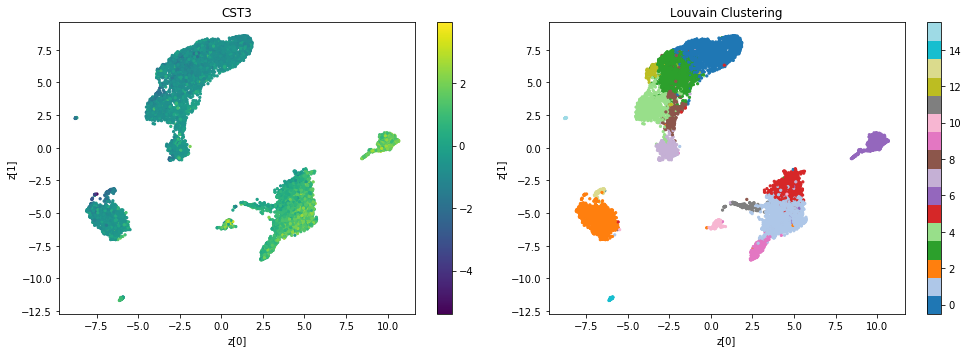

ARI = 0.5635363401545793
AMI = 0.7116545693824782


In [16]:
RES=1.0
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [5]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [6]:
model = AAE2(**parameters)

In [7]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [8]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,100,batch size
epochs,200,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [10]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC10k/graphs/autoencoder.png)

### Train the model


In [4]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

NameError: name 'model' is not defined

Epoch 22/200, rec. loss: 0.812552, dis. loss: 0.217797, cat. dis. loss: 0.485258


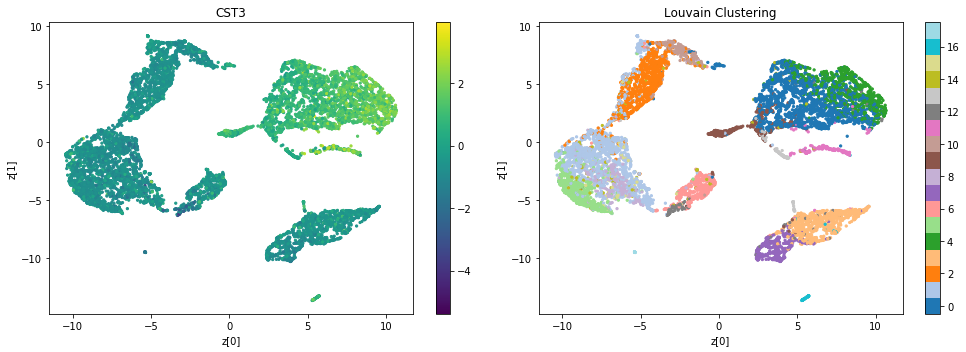

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [19]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
RES=0.6
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 100,
    'layers_enc_dim': [1000, 500, 400, 300, 200],
    'layers_dec_dim': [200, 300, 400, 500, 1000],
    'batch_size': 1000,
    'epochs': 5000
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,5000,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,100,dimension of latent space Z
layer_1_enc_dim,1000,dimension of encoder dense layer 1


In [ ]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

INFO:tensorflow:Enabled multi-worker collective ops with available devices: ['/job:worker/replica:0/task:0/device:CPU:0', '/job:worker/replica:0/task:0/device:XLA_CPU:0', '/job:worker/replica:0/task:0/device:XLA_GPU:0', '/job:worker/replica:0/task:0/device:XLA_GPU:1', '/job:worker/replica:0/task:0/device:GPU:0', '/job:worker/replica:0/task:0/device:GPU:1']
INFO:tensorflow:Multi-worker CollectiveAllReduceStrategy with cluster_spec = {'worker': ['localhost:2223', 'localhost:2223']}, task_type = 'worker', task_id = 0, num_workers = 2, local_devices = ('/job:worker/task:0/device:GPU:0', '/job:worker/task:0/device:GPU:1'), communication = CollectiveCommunication.NCCL


In [ ]:
# Model summary

model.get_summary()

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [12]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc10k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
INFO:tensorflow:Running Distribute Coordinator with mode = 'independent_worker', cluster_spec = {'worker': ['s32p35.deic.sdu.dk:2222']}, task_type = 'worker', task_id = 0, environment = None, rpc_layer = 'grpc'
INFO:tensorflow:Multi-worker CollectiveAllReduceStrategy with cluster_spec = {'worker': ['s32p35.deic.sdu.dk:2222']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0/device:GPU:0', '/job:worker/task:0/device:GPU:1'), communication = CollectiveCommunication.AUTO
INFO:tensorflow:Multi-worker CollectiveAllReduceStrategy with cluster_spec = {'worker': ['s32p35.deic.sdu.dk:2222']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0/device:GPU:0', '/job:worker/task:0/device:GPU:1'), communication = CollectiveCommunication.AUTO
Train for 4 steps, validate for 1 steps
Epoch 1/5000
INFO:tensorflow:Collective batch_all_reduce: 46 all-reduces, num_workers = 1
INFO:tensorflow:Collective ba

4/4 [==============================] - 0s 109ms/step - loss: 1785.5295 - val_loss: 1830.1946
Epoch 138/5000
4/4 [==============================] - 0s 109ms/step - loss: 1785.8109 - val_loss: 1830.2068
Epoch 139/5000
4/4 [==============================] - 0s 111ms/step - loss: 1790.2993 - val_loss: 1829.8931
Epoch 140/5000
4/4 [==============================] - 0s 107ms/step - loss: 1789.8967 - val_loss: 1829.4497
Epoch 141/5000
4/4 [==============================] - 0s 111ms/step - loss: 1792.9420 - val_loss: 1829.2971
Epoch 142/5000
4/4 [==============================] - 0s 107ms/step - loss: 1792.5464 - val_loss: 1829.2478
Epoch 143/5000
4/4 [==============================] - 0s 107ms/step - loss: 1788.4555 - val_loss: 1829.1855
Epoch 144/5000
4/4 [==============================] - 0s 114ms/step - loss: 1788.6829 - val_loss: 1828.4398
Epoch 145/5000
4/4 [==============================] - 0s 114ms/step - loss: 1796.1544 - val_loss: 1828.6335
Epoch 146/5000
4/4 [=======================

Epoch 213/5000
4/4 [==============================] - 0s 110ms/step - loss: 1778.9249 - val_loss: 1819.2653
Epoch 214/5000
4/4 [==============================] - 0s 111ms/step - loss: 1777.3312 - val_loss: 1819.1968
Epoch 215/5000
4/4 [==============================] - 0s 109ms/step - loss: 1774.2803 - val_loss: 1818.9524
Epoch 216/5000
4/4 [==============================] - 0s 111ms/step - loss: 1784.2519 - val_loss: 1819.1040
Epoch 217/5000
4/4 [==============================] - 0s 109ms/step - loss: 1771.7744 - val_loss: 1819.3301
Epoch 218/5000
4/4 [==============================] - 0s 107ms/step - loss: 1774.4503 - val_loss: 1818.7145
Epoch 219/5000
4/4 [==============================] - 0s 113ms/step - loss: 1769.0445 - val_loss: 1818.7427
Epoch 220/5000
4/4 [==============================] - 0s 114ms/step - loss: 1774.1540 - val_loss: 1818.6227
Epoch 221/5000
4/4 [==============================] - 0s 109ms/step - loss: 1779.3449 - val_loss: 1818.5450
Epoch 222/5000
4/4 [========

Epoch 289/5000
4/4 [==============================] - 0s 111ms/step - loss: 1764.7314 - val_loss: 1814.2361
Epoch 290/5000
4/4 [==============================] - 0s 115ms/step - loss: 1775.4379 - val_loss: 1814.3442
Epoch 291/5000
4/4 [==============================] - 0s 115ms/step - loss: 1760.8235 - val_loss: 1814.1920
Epoch 292/5000
4/4 [==============================] - 0s 114ms/step - loss: 1769.3418 - val_loss: 1814.2313
Epoch 293/5000
4/4 [==============================] - 0s 114ms/step - loss: 1777.0063 - val_loss: 1813.8694
Epoch 294/5000
4/4 [==============================] - 0s 109ms/step - loss: 1773.8918 - val_loss: 1813.8992
Epoch 295/5000
4/4 [==============================] - 0s 110ms/step - loss: 1767.5374 - val_loss: 1813.6589
Epoch 296/5000
4/4 [==============================] - 0s 112ms/step - loss: 1767.3120 - val_loss: 1814.0122
Epoch 297/5000
4/4 [==============================] - 0s 108ms/step - loss: 1780.2562 - val_loss: 1814.0852
Epoch 298/5000
4/4 [========

Epoch 365/5000
4/4 [==============================] - 0s 105ms/step - loss: 1768.0503 - val_loss: 1810.8933
Epoch 366/5000
4/4 [==============================] - 0s 113ms/step - loss: 1764.4006 - val_loss: 1810.8591
Epoch 367/5000
4/4 [==============================] - 0s 112ms/step - loss: 1767.2125 - val_loss: 1810.9014
Epoch 368/5000
4/4 [==============================] - 0s 109ms/step - loss: 1769.4118 - val_loss: 1810.7463
Epoch 369/5000
4/4 [==============================] - 0s 107ms/step - loss: 1767.0919 - val_loss: 1811.0681
Epoch 370/5000
4/4 [==============================] - 0s 109ms/step - loss: 1750.4905 - val_loss: 1810.8925
Epoch 371/5000
4/4 [==============================] - 0s 110ms/step - loss: 1766.9212 - val_loss: 1810.8297
Epoch 372/5000
4/4 [==============================] - 0s 108ms/step - loss: 1756.9021 - val_loss: 1810.8130
Epoch 373/5000
4/4 [==============================] - 0s 111ms/step - loss: 1763.3010 - val_loss: 1810.7354
Epoch 374/5000
4/4 [========

Epoch 441/5000
4/4 [==============================] - 0s 111ms/step - loss: 1758.3928 - val_loss: 1809.5837
Epoch 442/5000
4/4 [==============================] - 0s 112ms/step - loss: 1751.6043 - val_loss: 1809.3113
Epoch 443/5000
4/4 [==============================] - 0s 111ms/step - loss: 1754.5209 - val_loss: 1809.4279
Epoch 444/5000
4/4 [==============================] - 0s 112ms/step - loss: 1756.1873 - val_loss: 1809.3301
Epoch 445/5000
4/4 [==============================] - 0s 105ms/step - loss: 1761.2701 - val_loss: 1809.4949
Epoch 446/5000
4/4 [==============================] - 0s 112ms/step - loss: 1761.8030 - val_loss: 1809.4453
Epoch 447/5000
4/4 [==============================] - 0s 110ms/step - loss: 1764.7500 - val_loss: 1809.2455
Epoch 448/5000
4/4 [==============================] - 0s 114ms/step - loss: 1759.2498 - val_loss: 1809.3062
Epoch 449/5000
4/4 [==============================] - 0s 109ms/step - loss: 1762.9621 - val_loss: 1809.2401
Epoch 450/5000
4/4 [========

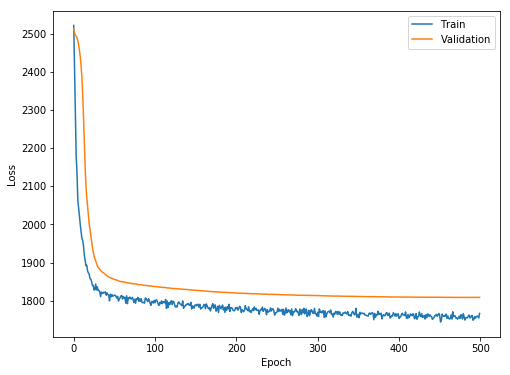

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

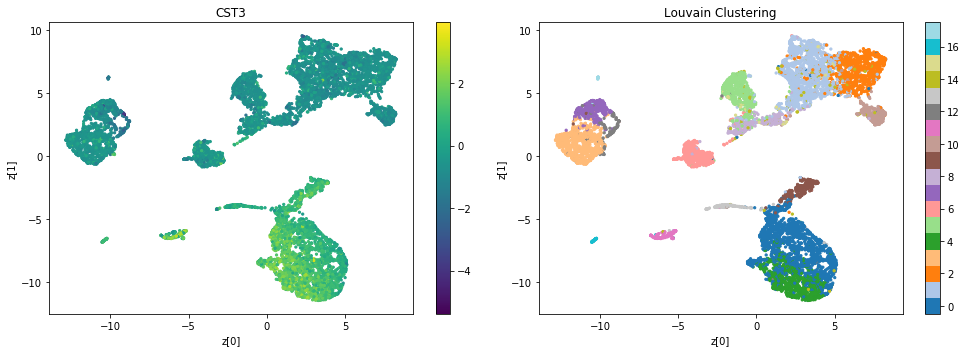

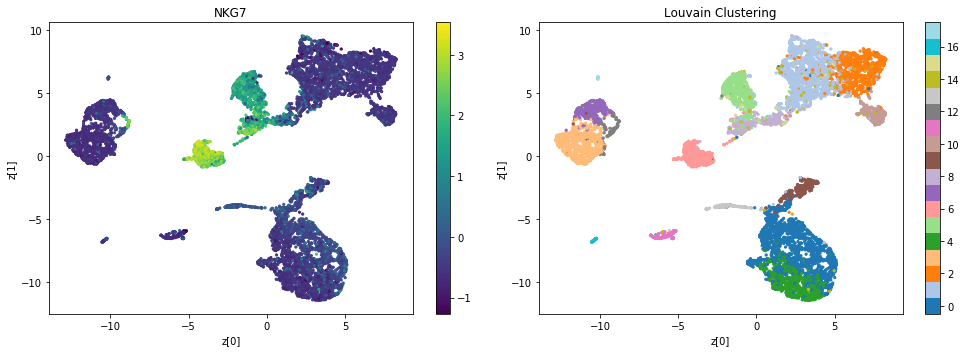

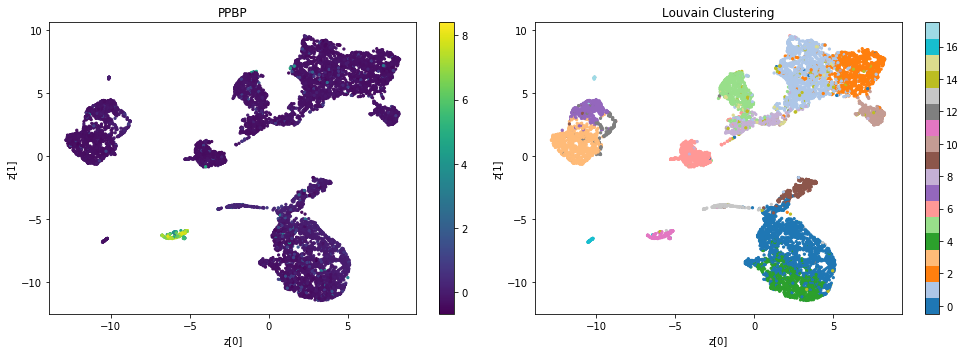

In [14]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/VAE/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

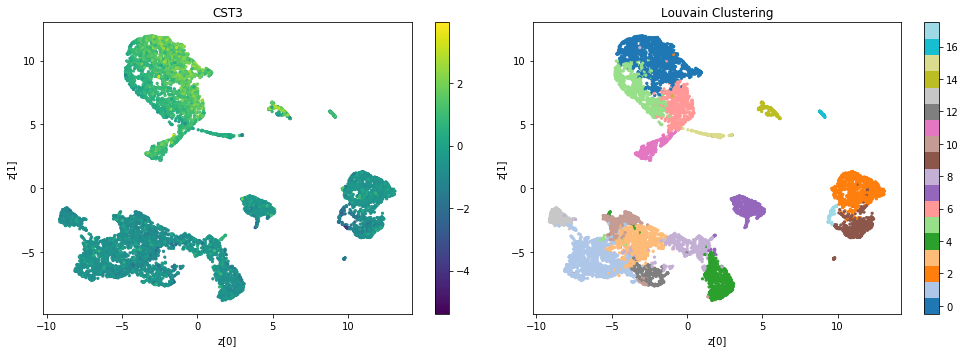

ARI = 0.5429981081043974
AMI = 0.7269902245328521


In [19]:
RES=0.6
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))